<a href="https://colab.research.google.com/github/ahmad-PH/nag-notebooks/blob/master/NAG_tripletLossExperiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [121]:
import os; import subprocess

def detect_env():
    return 'colab' if 'content' in os.listdir('/') else 'IBM'
  
def run_shell_command(cmd):
  p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE)
  print(str(p.communicate()[0], 'utf-8'))
  
if detect_env() == 'colab': root_folder = '/content'
elif detect_env() == 'IBM' : root_folder = '/root/Derakhshani/adversarial'
python_files_path = root_folder + '/nag-public'

if os.path.isdir(python_files_path):
  initial_dir = os.getcwd()
  os.chdir(python_files_path)
  run_shell_command('git pull')
  os.chdir(initial_dir)
else:
  os.chdir('/root/Derakhshani/adversarial')
  run_shell_command('git clone https://github.com/ahmad-PH/nag-public.git')

Already up-to-date.



In [122]:
import sys
sys.path.append(python_files_path + '/NAG-11May-beforeDenoiser')

from nag_util import *
import nag_util
from environment import *
from visualization import *

env = create_env()
env.setup(cuda_index = 0)

In [123]:
from fastai.vision import *
from fastai.imports import *
from fastai.callbacks import *
from fastai.utils.mem import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import sys; import os; import shutil

In [124]:
class GeneralRelu(nn.Module):
  def __init__(self, leak=None, sub=None, maxv=None):
    super().__init__()
    self.leak,self.sub,self.maxv = leak,sub,maxv

  def forward(self, x): 
    x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
    if self.sub is not None: x.sub_(self.sub)
    if self.maxv is not None: x.clamp_max_(self.maxv)
    return x
  
class deconv_layer(nn.Module):
    def __init__(self, in_ch, out_ch, k_size = (4,4), s = (2,2), pad = (1,1), b = True, activation = True):
        super(deconv_layer, self).__init__()

        self.CT2d = nn.ConvTranspose2d(in_channels = in_ch,
                                  out_channels = out_ch,
                                  kernel_size = k_size,
                                  stride = s, 
                                  padding = pad,
                                  bias = b)
        self.BN2d = nn.BatchNorm2d(out_ch)
        
        self.activation = activation
        if self.activation:
            self.relu = GeneralRelu(0, 0.2, 5)
        
        self.weight_init()
    
    def forward(self, input):
        if self.activation:
            return self.relu(self.BN2d(self.CT2d(input)))
        else:
            return self.BN2d(self.CT2d(input))

    def weight_init(self):
        self.CT2d.weight.data.normal_(mean = 0, std = 0.02)
        self.CT2d.bias.data.fill_(0)


In [125]:
# class Gen(nn.Module):
#   def __init__(self, z_dim, gf_dim=64, y_dim = None, df_dim = 64, image_shape = [3,128,128]):
#     super(Gen, self).__init__()

#     self.bs = None
#     self.z_dim = z_dim
#     self.gf_dim = gf_dim
#     self.y_dim = y_dim
#     self.df_dim = df_dim
#     self.image_shape = image_shape

#     self.z_ = nn.Linear(self.z_dim, self.gf_dim * 7 * 4 * 4, bias=True)
#     self.z_.bias.data.fill_(0)
#     self.BN_ = nn.BatchNorm2d(self.gf_dim * 7)

#     self.half = max(self.gf_dim // 2, 1) 
#     self.quarter = max(self.gf_dim // 4, 1)
#     self.eighth = max(self.gf_dim // 8, 1)
#     # sixteenth = max(self.gf_dim // 16, 1)
    
#     self.CT2d_1 = deconv_layer(self.gf_dim * 8, self.gf_dim * 4, k_size = (5,5), pad = (2,2))
#     self.CT2d_2 = deconv_layer(self.gf_dim * 5, self.gf_dim * 2)    
#     self.CT2d_3 = deconv_layer(self.gf_dim * 2 + self.half, self.gf_dim * 1)
#     self.CT2d_4 = deconv_layer(self.gf_dim * 1 + self.quarter, self.gf_dim * 1)
#     self.CT2d_5 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
#     self.CT2d_6 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
#     self.CT2d_7 = deconv_layer(self.gf_dim * 1 + self.eighth, 3, k_size = (5,5), s = (1,1), pad = (2,2), activation = False)

#   def randomized_deconv_layer(self, h_input, z_size_0, z_size_1, deconv_layer, expected_output_size):
#     h_input_z = self.make_z([self.bs, z_size_0, z_size_1, z_size_1])
#     h_input = torch.cat([h_input, h_input_z], dim = 1)
#     output = deconv_layer(h_input)
#     assert output.shape[2:] == (expected_output_size, expected_output_size), \
#             "Unexpected output shape at randomized_deconv_layer. expected" + \
#             "({0},{0}), got {1}".format(expected_output_size, output.shape[2:])
#     return output
  
#   def forward_z(self, z):
#     self.bs = z.shape[0]
    
#     h0 = F.relu(self.BN_(self.z_(z).contiguous().view(self.bs, -1, 4, 4)))
#     assert h0.shape[2:] == (4, 4), "Unexpected shape, it shoud be (4,4)"

#     h1 = self.randomized_deconv_layer(h0, self.gf_dim, 4, self.CT2d_1, 7)
#     h2 = self.randomized_deconv_layer(h1, self.gf_dim, 7, self.CT2d_2, 14)
#     h3 = self.randomized_deconv_layer(h2, self.half, 14, self.CT2d_3, 28)
#     h4 = self.randomized_deconv_layer(h3, self.quarter, 28, self.CT2d_4, 56)
#     h5 = self.randomized_deconv_layer(h4, self.eighth, 56, self.CT2d_5, 112)
#     h6 = self.randomized_deconv_layer(h5, self.eighth, 112, self.CT2d_6, 224)
#     h7 = self.randomized_deconv_layer(h6, self.eighth, 224, self.CT2d_7, 224)

#     ksi = 10.0
#     output_coeff = ksi / (255.0 * np.mean(imagenet_stats[1])) 
#     # this coeff scales the output to be appropriate for images that are 
#     # normalized using imagenet_stats (and are hence in the approximate [-2.5, 2.5]
#     # interval)
#     return output_coeff * torch.tanh(h7)
  
# #   # blind-selection
#   def forward(self, inputs):
#     self.bs = inputs.shape[0]

#     benign_preds_onehot = arch(inputs)
#     benign_preds = torch.argmax(benign_preds_onehot, dim = 1)
    
#     z = torch.zeros([self.bs, 1000]).cuda()
#     for i in range(self.bs):
#       random_label = self.randint(0,1000, exclude = benign_preds[i].item())
#       z[i][random_label] = 1.
    
#     z_out = self.forward_z(z)
    
#     return z_out, None, None, inputs, benign_preds_onehot, z

# #   #second-best selection: made validation so much worse
# #   def forward(self, inputs):
# #     self.bs = inputs.shape[0]

# #     benign_preds_onehot = arch(inputs)
# #     target_preds = torch.topk(benign_preds_onehot, 2, dim = 1).indices[:, 1:]
    
# #     z = torch.zeros([self.bs, 1000]).cuda()
# #     for i in range(self.bs):
# #       z[i][target_preds[i]] = 1.
    
# #     z_out = self.forward_z(z)
    
# #     return z_out, None, None, inputs, benign_preds_onehot, z
  
# #    def forward(self, inputs):
# #     self.bs = inputs.shape[0]

# #     benign_preds_onehot = arch(inputs)
# #     benign_preds = torch.argmax(benign_preds_onehot, dim = 1)
    
# #     z = torch.zeros([self.bs, 1000]).cuda()
# #     random_label = self.randint(0,1000, exclude = benign_preds.tolist())
# #     for i in range(self.bs):
# #       z[i][random_label] = 1.
    
# #     z_out = self.forward_z(z)
    
# #     return z_out, None, None, inputs, benign_preds_onehot, z
  
#   @staticmethod
#   def randint(low, high, exclude):
#     temp = np.random.randint(low, high - 1)
#     if temp == exclude:
#       temp = temp + 1
#     return temp
  
#   def forward_single_z(self, z):
#     return self.forward_z(z[None]).squeeze()
           
  
#   def make_triplet_samples(self, z, margin, r2, r3):
#     positive_sample = z + self.random_vector_volume(z.shape, 0, margin).cuda() 
#     negative_sample = z + self.random_vector_volume(z.shape, r2, r3).cuda()
#     return positive_sample, negative_sample

#   def random_vector_surface(self, shape, r = 1.):
#     mat = torch.randn(size=shape).cuda()
#     norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
#     return (mat/norm) * r

  
#   def random_vector_volume(self, shape, inner_r, outer_r):
#     fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
#     fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
#     fraction.unsqueeze_(-1)
#     return self.random_vector_surface(shape, 1) * fraction

#   def make_z(self, in_shape):
#     return torch.empty(in_shape).cuda().uniform_(-1,1)


In [126]:
# non-targeted Gen
class Gen(nn.Module):
  def __init__(self, z_dim, gf_dim=64, y_dim = None, df_dim = 64, image_shape = [3,128,128]):
    super(Gen, self).__init__()

    self.bs = None
    self.z_dim = z_dim
    self.gf_dim = gf_dim
    self.y_dim = y_dim
    self.df_dim = df_dim
    self.image_shape = image_shape

    self.z_ = nn.Linear(self.z_dim, self.gf_dim * 7 * 4 * 4, bias=True)
    self.z_.bias.data.fill_(0)
    self.BN_ = nn.BatchNorm2d(self.gf_dim * 7)

    self.half = max(self.gf_dim // 2, 1) 
    self.quarter = max(self.gf_dim // 4, 1)
    self.eighth = max(self.gf_dim // 8, 1)
    # sixteenth = max(self.gf_dim // 16, 1)

    self.CT2d_1 = deconv_layer(self.gf_dim * 8, self.gf_dim * 4, k_size = (5,5), pad = (2,2))
    self.CT2d_2 = deconv_layer(self.gf_dim * 5, self.gf_dim * 2)    
    self.CT2d_3 = deconv_layer(self.gf_dim * 2 + self.half, self.gf_dim * 1)
    self.CT2d_4 = deconv_layer(self.gf_dim * 1 + self.quarter, self.gf_dim * 1)
    self.CT2d_5 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
    self.CT2d_6 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
    self.CT2d_7 = deconv_layer(self.gf_dim * 1 + self.eighth, 3, k_size = (5,5), s = (1,1), pad = (2,2), activation = False)

  def randomized_deconv_layer(self, h_input, z_size_0, z_size_1, deconv_layer, expected_output_size):
    h_input_z = self.make_z([self.bs, z_size_0, z_size_1, z_size_1])
    h_input = torch.cat([h_input, h_input_z], dim = 1)
    output = deconv_layer(h_input)
    assert output.shape[2:] == (expected_output_size, expected_output_size), \
            "Unexpected output shape at randomized_deconv_layer. expected" + \
            "({0},{0}), got {1}".format(expected_output_size, output.shape[2:])
    return output
  
  def forward_z(self, z):
    self.bs = z.shape[0]
    
    h0 = F.relu(self.BN_(self.z_(z).contiguous().view(self.bs, -1, 4, 4)))
    assert h0.shape[2:] == (4, 4), "Non-expected shape, it shoud be (4,4)"

    h1 = self.randomized_deconv_layer(h0, self.gf_dim, 4, self.CT2d_1, 7)
    h2 = self.randomized_deconv_layer(h1, self.gf_dim, 7, self.CT2d_2, 14)
    h3 = self.randomized_deconv_layer(h2, self.half, 14, self.CT2d_3, 28)
    h4 = self.randomized_deconv_layer(h3, self.quarter, 28, self.CT2d_4, 56)
    h5 = self.randomized_deconv_layer(h4, self.eighth, 56, self.CT2d_5, 112)
    h6 = self.randomized_deconv_layer(h5, self.eighth, 112, self.CT2d_6, 224)
    h7 = self.randomized_deconv_layer(h6, self.eighth, 224, self.CT2d_7, 224)

    ksi = 10.0
    output_coeff = ksi / (255.0 * np.mean(imagenet_stats[1])) 
    # this coeff scales the output to be appropriate for images that are 
    # normalized using imagenet_stats (and are hence in the approximate [-2.5, 2.5]
    # interval)
    return output_coeff * torch.tanh(h7)

  def forward(self, inputs):
    self.bs = inputs.shape[0]
    z = inputs.new_empty([self.bs, self.z_dim]).uniform_(-1,1).cuda()
    p, n = self.make_triplet_samples(z, 0.1, 0.1, 2.)
    
    z_out = self.forward_z(z)
    p_out = self.forward_z(p)
    n_out = self.forward_z(n)
    
    return z_out, p_out, n_out, inputs
#     return z_out, None, None, inputs
  
  def forward_single_z(self, z):
    return self.forward_z(z[None]).squeeze()
  
  def generate_single_noise(self):
    z = torch.empty(self.z_dim).uniform_(-1,1).cuda()
    return self.forward_single_z(z)
           
  
  def make_triplet_samples(self, z, margin, r2, r3):
    positive_sample = z + self.random_vector_volume(z.shape, 0, margin).cuda() 
    negative_sample = z + self.random_vector_volume(z.shape, r2, r3).cuda()
    return positive_sample, negative_sample

  def random_vector_surface(self, shape, r = 1.):
    mat = torch.randn(size=shape).cuda()
    norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
    return (mat/norm) * r

  
  def random_vector_volume(self, shape, inner_r, outer_r):
    fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
    fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
    fraction.unsqueeze_(-1)
    return self.random_vector_surface(shape, 1) * fraction

  def make_z(self, in_shape):
    return torch.empty(in_shape).cuda().uniform_(-1,1)

In [127]:
def js_distance(x1, x2):
  m = 0.5 * (x1 + x2)
  return 0.5 * (F.kl_div(x1, m) + F.kl_div(x2, m))

def kl_distance(x1, x2):
  inp = torch.log(x1)
  target = x2
  return F.kl_div(inp, target, reduction='batchmean')

def distrib_distance(x1, x2):
  x1 = tensorify(x1)
  x2 = tensorify(x2)
  x1 = x1 / torch.sum(x1)
  x2 = x2 / torch.sum(x2)
  return kl_distance(x1[None], x2[None])

def distrib_distance(x1, x2):
  if not isinstance(x1, torch.Tensor): x1 = torch.tensor(x1)
  if not isinstance(x2, torch.Tensor): x2 = torch.tensor(x2)
  x1 = x1 * 100. / torch.sum(x1)
  x2 = x2 * 100. / torch.sum(x2)
  return torch.norm(x1 - x2, 2)

def distance_from_uniform(x):
  return distrib_distance(x, [1.] * len(x))

def wasserstein_distance(x1, x2):
  return torch.mean(x1 - x2)

def l1_distance(x1, x2):
  return F.l1_loss(x1, x2)

def l2_distance(x1, x2):
  return F.mse_loss(x1 * 10, x2 * 10)

def mse_loss(x1, x2):
  return F.mse_loss(x1, x2)

def cos_distance(x1, x2, dim = 1):
  return -1 * torch.mean(F.cosine_similarity(x1, x2, dim=dim))


def triplet_loss(anchor, positive, negative, distance_func, margin):
  # max distance when using l1_distance is 2
  # max distacne when using l2-distance is sqrt(2)
#   print("anchor: ", anchor.min(), anchor.max())
  ap_dist = distance_func(anchor, positive)
  an_dist = distance_func(anchor, negative)

  triplet_loss.call_count += 1
  if triplet_loss.call_count % 10 in [0,1] : #and anchor.shape[1] == 1000:
#     print("a: ", end=""); print_big_vector(anchor[0])
#     print("p: ", end=""); print_big_vector(positive[0])
#     print("n: ", end=""); print_big_vector(negative[0])
    print("func:{}, ap_dist: {}, an_dist: {}".format(distance_func.__name__, ap_dist, an_dist))
    
  return torch.mean(F.relu(ap_dist - an_dist + margin))

triplet_loss.call_count = 0

In [128]:
def diversity_loss(input, target):
#   return -1 * torch.mean(torch.pow(f_x_a-f_x_s,2))
  if input.shape[0] != batch_size:
    print("input shape: ", input.shape)
    print("target shape: ", target.shape, "\n\n")
  return torch.mean(F.cosine_similarity(
    input.view([batch_size, -1]),
    target.view([batch_size, -1]), 
  ))


def fool_loss(input, target):
  true_class = torch.argmax(target, dim=1).view(-1,1).long().cuda()
  target_probabilities = input.gather(1, true_class)
  epsilon = 1e-10
  result =  torch.mean(-1 * torch.log(1 - target_probabilities + epsilon))
  
  fool_loss.call_count += 1
  if fool_loss.call_count % 40 == 0:
    print("target probs {}, loss: {}: ".format(target_probabilities, result))
    
  return result

fool_loss.call_count = 0

# def fool_loss(model_output, target_labels):
#   target_labels = target_labels.view(-1, 1).long().cuda()
#   target_probabilities = model_output.gather(1, target_labels)
#   epsilon = 1e-10
#   # highest possible fool_loss is - log(1e-10) == 23
#   result = torch.mean(-1 * torch.log(target_probabilities + epsilon))
  
#   global fool_loss_count
#   fool_loss_count += 1
#   if fool_loss_count % 20 == 0:
#     print("target probs {}, loss: {}: ".format(target_probabilities, result))
  
#   return result

# def validation(gen_output, target):
#   perturbations, _, _, clean_images, _, _ = gen_output
#   perturbed_images = clean_images + perturbations
#   benign_preds = torch.argmax(arch(clean_images), 1)
#   adversary_preds = torch.argmax(arch(perturbed_images), 1)
#   return (benign_preds != adversary_preds).float().mean()

def validation(gen_output, target):
  perturbations, _, _, clean_images = gen_output
  perturbed_images = clean_images + perturbations
  benign_preds = torch.argmax(arch(clean_images), 1)
  adversary_preds = torch.argmax(arch(perturbed_images), 1)
  return (benign_preds != adversary_preds).float().mean()


In [129]:
# class FeatureLoss(nn.Module):
#     def __name__(self):
#       return "feature_loss"
  
#     def __init__(self, dis, layers, layer_weights):
#         super().__init__()
        
#         # define generator here 
#         self.dis = dis
#         self.diversity_layers = layers
#         self.hooks = hook_outputs(self.diversity_layers, detach=False)
#         self.weights = layer_weights
#         self.metric_names = ["fool_loss"] #+ [f"div_loss_{i}" for i in range(len(layers))] #maybe Gram
# #         self.triplet_hooks = hook_outputs([arch.m.features[4]], detach=False)
    
#     def make_features(self, x, clone=False):
#         y = self.dis(x)
#         return y, [(o.clone() if clone else o) for o in self.hooks.stored]
  
#     def forward(self, inp, target):
#       sigma_B, _, _, X_B, B_Y, z = inp

#       X_A = X_B + sigma_B
# #       X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

#       A_Y, A_feat = self.make_features(X_A)
# #       _, S_feat = self.make_features(X_S)

#       chosen_labels = z.argmax(dim=1)
#       fooling_loss =  fool_loss(A_Y, chosen_labels)

# #       raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
# #       weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]

# #       self.losses = [fooling_loss] + weighted_diversity_losses
# #       self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses))

#       self.losses = [fooling_loss]
#       self.metrics = dict(zip(self.metric_names, [fooling_loss]))

#       return sum(self.losses)
  
#     def add_perturbation_shuffled(self, inp, perturbation):
# #         j = torch.randperm(inp.shape[0])
#         j = derangement(inp.shape[0])
#         return inp.add(perturbation[j])

In [130]:
#non-targeted FeatureLoss
class FeatureLoss(nn.Module):
    def __name__(self):
      return "feature_loss"
  
    def __init__(self, dis, layers, layer_weights):
        super().__init__()
        
        self.dis = dis
        self.diversity_layers = layers
        self.hooks = hook_outputs(self.diversity_layers, detach=False)
        self.weights = layer_weights
        
        self.metric_names = ["fool_loss"] + [f"div_loss_{i}" for i in range(len(layers))] + ['triplet_loss']# Maybe Gram
#         self.metric_names = ["fool_loss"] + ['triplet_loss']# Maybe Gram
#         self.metric_names = ["fool_loss"] + ['div_loss']# Maybe Gram
        self.triplet_weight = 4.
        self.div_weight = 1.
    
    def make_features(self, x, clone=False):
        y = self.dis(x)
        return y, [(o.clone() if clone else o) for o in self.hooks.stored]
    
#     triplet loss
    def forward(self, inp, target):
        sigma_B, sigma_pos, sigma_neg, X_B = inp

        X_A = self.add_perturbation(X_B, sigma_B) 
        X_A_pos = self.add_perturbation(X_B, sigma_pos)
        X_A_neg = self.add_perturbation(X_B, sigma_neg) 
        
        X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples
        
        B_Y, _ = self.make_features(X_B)
        A_Y, A_feat = self.make_features(X_A)
        _, S_feat = self.make_features(X_S)
        pos_softmax, _ = self.make_features(X_A_pos)
        neg_softmax, _ = self.make_features(X_A_neg)
        
        fooling_loss =  fool_loss(A_Y, B_Y)
      
        raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
        weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight * self.div_weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]
        raw_triplet_loss = triplet_loss(A_Y, pos_softmax, neg_softmax, cos_distance, 1.4)
        weighted_triplet_loss = raw_triplet_loss * self.triplet_weight
    
#         self.losses = weighted_diversity_losses + [weighted_triplet_loss]
#         self.metrics = dict(zip(self.metric_names, raw_diversity_losses + [raw_triplet_loss]))
        
        self.losses = [fooling_loss] + weighted_diversity_losses + [weighted_triplet_loss]
        self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses + [raw_triplet_loss]))
        
#         self.losses = [fooling_loss] + [weighted_triplet_loss]
#         self.metrics = dict(zip(self.metric_names, [fooling_loss] + [raw_triplet_loss]))

        return sum(self.losses)


#     #use two types of triplet losses
#     def forward(self, inp, target):
#       sigma_B, sigma_pos, sigma_neg, X_B = inp

#       X_A = self.add_perturbation(X_B, sigma_B) 
#       X_A_pos = self.add_perturbation(X_B, sigma_pos)
#       X_A_neg = self.add_perturbation(X_B, sigma_neg) 

#       X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

#       B_Y, _ = self.make_features(X_B)
#       A_Y, A_feat = self.make_features(X_A)
#       _, S_feat = self.make_features(X_S)
#       pos_softmax, _ = self.make_features(X_A_pos)
#       neg_softmax, _ = self.make_features(X_A_neg)

#       fooling_loss =  fool_loss(A_Y, B_Y)

#       raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
#       weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight * self.div_weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]
      
#       raw_triplet_loss_sm = triplet_loss(A_Y, pos_softmax, neg_softmax, cos_distance, 1.4)
#       weighted_triplet_loss_sm = raw_triplet_loss_sm * self.triplet_weight_sm
      
#       raw_triplet_loss_noise = triplet_loss(sigma_B, sigma_pos, sigma_neg, l2_distance, 5.)
#       weighted_triplet_loss_noise = raw_triplet_loss_noise * self.triplet_weight_noise

#       self.losses = [fooling_loss] + weighted_diversity_losses + [weighted_triplet_loss_sm, weighted_triplet_loss_noise] 
#       self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses + [weighted_triplet_loss_sm, weighted_triplet_loss_noise]))

#       return sum(self.losses)

#     # just fooling and diversity
#     def forward(self, inp, target):
#       sigma_B, sigma_pos, sigma_neg, X_B = inp

#       X_A = self.add_perturbation(X_B, sigma_B) 

#       X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

#       B_Y, _ = self.make_features(X_B)
#       A_Y, A_feat = self.make_features(X_A)
#       _, S_feat = self.make_features(X_S)

#       fooling_loss =  fool_loss(A_Y, B_Y)

#       raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
#       weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight * self.div_weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]

#       self.losses = [fooling_loss] + weighted_diversity_losses
#       self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses))

#       return sum(self.losses)
  
  
    def add_perturbation(self, inp, perturbation):
        return inp.add(perturbation)
  
    def add_perturbation_shuffled(self, inp, perturbation):
        j = derangement(inp.shape[0])
        return inp.add(perturbation[j])

In [131]:
import pandas as pd

def produce_summary(root_folder, n_files):
  def writeline(file, values, fmt_string):
    file.write(', '.join(fmt_string.format(v) for v in values) + '\n')
  
  last_rows = []
  for i in range(n_files):
    prefix = '/root/Derakhshani/adversarial/textual_notes/CSVs'
    df = pd.read_csv("{}/{}/{}.csv".format(prefix, root_folder, i))
    last_rows.append(df.iloc[-1][1:-1].values.tolist())
  
  last_rows = np.array(last_rows)
  
  labels = list(df.columns[1:-1])
  means = np.mean(last_rows, axis=0).tolist()
  outfile = open('{}/{}/summary.txt'.format(prefix, root_folder), 'w+')
  outfile.write('means: \n')
  writeline(outfile, labels, '{: >11}')
  writeline(outfile, means, '{: >11.3}')
  outfile.write('\n')
      
  operations = []
  for column in df.columns[1:-1]:
    if column in ['train_loss', 'valid_loss', 'fool_loss', 'triplet_loss'] or column[:8] == 'div_loss':
      operations.append('min')
    elif column in ['validation', 'div_metric']:
      operations.append('max')
    else:
      raise ValueError('column {} is not recognized'.format(column))
    
  results = []
  indexes = []
  
  for i in range(len(operations)):
    values = last_rows[:, i]
    if operations[i] == 'max': operation = np.max
    elif operations[i] == 'min': operation = np.min
    result = operation(values)
    results.append(result)
    indexes.append(values.tolist().index(result))
  
  outfile.write('bests: \n')
  writeline(outfile, labels, '{: >11}')
  writeline(outfile, operations, '{: >11}')
  writeline(outfile, results, '{: >11.3}')
  writeline(outfile, indexes, '{: >11}')

In [132]:
from distutils import dir_util 

def investigate_initial_settings(n_settings, n_epochs, lr, wd, results_dir):
  os.mkdir(env.get_csv_dir() + results_dir)
  os.mkdir(env.get_models_dir() + results_dir)
  
  for setting_ind in range(n_settings):
    print(f"investigation no: {n_settings}")
    learn = None; gen = None; gc.collect()
    gen = Gen(z_dim = z_dim)
    init_cnn(gen, True)
    div_metric = DiversityMetric(10, 95)
    
    tmp_csv_filename =  env.temp_csv_path + '/' + results_dir + '/' + str(setting_ind)
    csv_logger = partial(ImmediateCSVLogger, filename=tmp_csv_filename)
    
    learn = Learner(data, gen, loss_func = feat_loss, metrics=[validation, div_metric], 
                    model_dir = env.get_learner_models_dir(), callback_fns=[LossMetrics, csv_logger])
    div_metric.set_learner(learn)
    
    saver_best = SaveModelCallback(learn, every='improvement', monitor='validation', name=model.__name__ + "-best")
    saver_every_epoch = SaveModelCallback(learn, every='epoch', name=model.__name__)

    learn.fit(n_epochs, lr=lr, wd = wd, callbacks=[saver_best, saver_every_epoch])
    
    shutil.copyfile(tmp_csv_filename + ".csv", env.get_csv_dir() + results_dir + '/' + str(setting_ind) + '.csv')
    
    model_dest = env.get_models_dir() + results_dir + '/' + str(setting_ind)
    os.mkdir(model_dest)
    dir_util.copy_tree(env.data_path/env.get_learner_models_dir(), model_dest)
    shutil.rmtree(env.data_path/env.get_learner_models_dir())  
    
  produce_summary(results_dir, n_settings)

In [133]:
def generate_perturbations(learn, n_perturbations):
  initial_training_mode = learn.model.training
  gen = learn.model.eval()
  perturbations = [gen.generate_single_noise() for _ in range(n_perturbations)]
  learn.model.train(initial_training_mode)  
  return perturbations

def compute_prediction_histogram(learn, perturbation, verbose=False):
  pred_hist = [0] * 1000
  batch_no = -1
  for batch, _ in learn.data.valid_dl:
    batch_no += 1
    if batch_no % 100 == 0 and verbose: print ("at batch no {}".format(batch_no))
    perturbed_batch = batch + perturbation[None]
    preds = arch(perturbed_batch).argmax(1)
    for pred in preds:
      pred_hist[pred] += 1
  return pred_hist


def compute_mean_prediction_histogram(learn, perturbations):
  pred_hist = torch.tensor([0] * 1000).detach_()
  batch_no = -1
  for batch, _ in learn.data.valid_dl:
    batch_no += 1
    if batch_no % 5 == 0 : print(f"at batch no {batch_no}")
    for j, perturbation in enumerate(perturbations):
      perturbed_batch = batch + perturbation[None]
      preds = arch(perturbed_batch).argmax(1)
      for pred in preds:
        pred_hist[pred] += 1
  pred_hist = pred_hist.float() / len(perturbations)
  return pred_hist.tolist()


def classes_needed_to_reach(percentage, hist):
  hist_sum = np.sum(hist)
  indexed_hist = [(i, hist_element) for i,hist_element in  
                          enumerate(hist)]
  sorted_hist = sorted(indexed_hist, key=lambda x: x[1], reverse = True)
  
  cumulative_percent = 0
  n_used_classes = 0
  while cumulative_percent < percentage:
    hist_elem = sorted_hist[n_used_classes]
    cumulative_percent += (hist_elem[1] / hist_sum) * 100.
    n_used_classes += 1

  return n_used_classes, sorted_hist

def diversity(learn, n_perturbations, percentage = 95, p = None):
  pred_histogram = compute_mean_prediction_histogram(
      learn, generate_perturbations(learn, n_perturbations)
  )
  print("finished creating the prediction histogram")

  return classes_needed_to_reach(95, pred_histogram)

In [134]:
class DiversityMetric(Callback):
  def __init__(self, n_perturbations, percentage):
    super().__init__()
    self.name = "div_metric"
    self.n_perturbations = n_perturbations
    self.percentage = percentage
    self.learn = None
  
  def set_learner(self, learn):
    self.learn = learn
    
  def on_epoch_begin(self, **kwargs):
    global learn
    self.perturbations = generate_perturbations(self.learn, self.n_perturbations)
    self.pred_hist = torch.tensor([0] * 1000).detach_()
    
  def on_batch_end(self, last_output, last_target, **kwargs):
    _, _, _, images = last_output
    for j, perturbation in enumerate(self.perturbations):
      perturbed_batch = images + perturbation[None]
      preds = arch(perturbed_batch).argmax(1)
      for pred in preds:
        self.pred_hist[pred] += 1
  
  def on_epoch_end(self, last_metrics, **kwargs):
    self.pred_hist = (self.pred_hist.float() / len(self.perturbations)).tolist()
    div_metric = classes_needed_to_reach(self.percentage, self.pred_hist)[0]
    return add_metrics(last_metrics, div_metric)

In [135]:
# mode = "sanity_check"
mode = "normal"
# mode = "div_metric_calc"

In [136]:
model = models.resnet50
# model = models.resnet152
# model = models.vgg16_bn
# model = torchvision.models.googlenet

In [137]:
if mode == "normal":
  env.load_dataset('dataset','data')
  env.set_data_path('dataset')
elif mode == "sanity_check":
  env.load_dataset('dataset_sanity_check_small', 'dataset_sanity_check_small')  
  env.set_data_path('dataset_sanity_check_small')
elif mode == "div_metric_calc":
  env.load_dataset('dataset','data')
  env.set_data_path('dataset')
  env.load_test_dataset(str(env.data_path))

In [138]:
batch_size = 16
gpu_flag = True
nag_util.batch_size = batch_size; nag_util.gpu_flag = gpu_flag;
tfms = get_transforms(do_flip=False, max_rotate=0)
data = (ImageList.from_folder(env.data_path)
        .split_by_folder(valid=('test' if mode == 'div_metric_calc' else 'valid'))
        .label_from_folder()
        .transform(tfms, size=224)
        .databunch(bs=batch_size, num_workers=1)
        .normalize(imagenet_stats))

# data.show_batch(rows=2, figsize=(5,5))

In [139]:
z_dim = 10
arch = SoftmaxWrapper(model(pretrained=True).cuda().eval())
nag_util.arch = arch
requires_grad(arch, False)

# vgg:
# layers = []
# blocks = [i-1 for i,o in enumerate(children(arch.features)) if isinstance(o, nn.MaxPool2d)]
# layers = [arch.features[i] for i in blocks]
# layer_weights = [1] * len(layers)

layers = [
    arch.softmax
]

layer_weights = [1.] * len(layers)

# inception:
# layers = [
#     arch.Conv2d_1a_3x3,
#     arch.Mixed_6e,
#     arch.Mixed_7a,
#     arch.fc    
# ]
# layer_weights = [1.0/4.0] * len(layers)

In [140]:
feat_loss = FeatureLoss(arch, layers, layer_weights)

In [141]:
env.save_filename = 'resnet50_x'
# env.save_filename = 'resnet50_17'
# env.save_filename = 'vgg16_32'

if Path(env.get_csv_path() + '.csv').exists(): raise FileExistsError("csv_path already exists")
if Path(env.get_models_path()).exists(): raise FileExistsError("models_path already exists")

In [142]:
learn = None; gen = None; gc.collect()
csv_logger = partial(ImmediateCSVLogger, filename= env.temp_csv_path + '/' + env.save_filename)
gen = Gen(z_dim=z_dim)
init_cnn(gen, True)
div_metric = DiversityMetric(10, 95)

learn = Learner(data, gen, loss_func = feat_loss, model_dir = env.get_learner_models_dir(),
                metrics=[validation, div_metric], callback_fns=[LossMetrics, csv_logger])

div_metric.set_learner(learn)

# learn = Learner(data, Gen(z_dim=10), loss_func = feat_loss, metrics=[validation], callback_fns=LossMetrics, opt_func = optim.SGD)
# learn = Learner(data, Gen(z_dim=z_dim), loss_func = feat_loss, metrics=[validation], callback_fns=[LossMetrics, DiversityWeightsScheduler])

# load_starting_point(learn, model.__name__, z_dim)
# random_seed(42, True)

models_directory returned is:  models/103


In [143]:
# !cp "/content/gdrive/My Drive/DL/models/vgg16_12-last.pth"  "/content/"
# learn.load('/content/vgg16_12-last')

# load_filename = 'resnet50-11_39'
# load_filename = 'resnet50_startpoint_0'
load_filename = 'resnet50_55/resnet50_55_6'
# load_filename = 'investigate_resnet50_7/7/resnet50_3'
# load_filename = 'vgg16_30/vgg16_30_69'
# load_filename = 'vgg16_12-last'

learn.load('/root/Derakhshani/adversarial/models/' + load_filename)

/root/anaconda3/envs/mmderakhshani/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GeneralRelu. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/root/anaconda3/envs/mmderakhshani/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/root/anaconda3/envs/mmderakhshani/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Gen. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/root/anaconda3/envs/mmderakhshani/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type deconv_layer. It won't be checked for c

Learner(data=ImageDataBunch;

Train: LabelList (9000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
n02454379,n02454379,n02454379,n02454379,n02454379
Path: /root/Derakhshani/adversarial/datasets/dataset;

Valid: LabelList (1000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
n02454379,n02397096,n02090379,n01729977,n02268853
Path: /root/Derakhshani/adversarial/datasets/dataset;

Test: None, model=Gen(
  (z_): Linear(in_features=10, out_features=7168, bias=True)
  (BN_): BatchNorm2d(448, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (CT2d_1): deconv_layer(
    (CT2d): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (BN2d): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): GeneralRelu()
  )
  (CT2d_2): deconv_layer(
    

In [144]:
try:
  load_filename
except NameError:
  load_filename = None

print("the selected settings are : ")
print("\tmode: {} \n\tnetw-under-attack: {} \n\tloss metrics: {}\n\t" + \
      "load filename: {} \n\tsave filename: {}\n".format(
      mode, model.__name__, feat_loss.metrics, load_filename , env.save_filename
))
print("please MAKE SURE that the config is correct.")

the selected settings are : 


AttributeError: 'FeatureLoss' object has no attribute 'metrics'

In [ ]:
# learn.lr_find(1e-6, 100)
# learn.recorder.plot()

In [ ]:
# results_dir = 'investigate_resnet50_7'
# investigate_initial_settings(8, 4, lr = 1e-2, wd = 0.0, results_dir = results_dir)
# shutil.rmtree(env.get_models_dir() + results_dir)
# shutil.rmtree(env.get_csv_dir() + results_dir)

In [27]:
if mode == "sanity_check":
  print("\n\n\nWARNING: you are training on a sanity_check dataset.\n\n\n\n")

saver_best = SaveModelCallback(learn, every='improvement', monitor='validation', name=env.save_filename + "-best")
saver_every_epoch = SaveModelCallback(learn, every='epoch', name=env.save_filename)

# with Hooks(gen, append_stats_normal) as hooks:
#   learn.fit(1, lr=5e-03, wd = 0., callbacks=[saver_best, saver_every_epoch])
  
learn.fit(10, lr=1e-3, wd = 0., callbacks=[saver_best, saver_every_epoch])

# # learn.fit(70, lr=1e-02, wd = 0.001, callbacks=[saver_best, saver_every_epoch])

# learn.fit(60, lr=1e-2, wd = 0.001, callbacks=[saver_best, saver_every_epoch])

# for i in range(10):
#   learn.fit_one_cycle(7, wd = 0.,max_lr=1., div_factor = 1000.) 
  
# learn.fit_one_cycle(5, max_lr=2e-2) #used for vgg-19-bn
# learn.fit_one_cycle(5, max_lr=3e-3) # used for resnet50

shutil.copyfile(env.temp_csv_path + '/' + env.save_filename + ".csv", env.get_csv_path() + '.csv')
shutil.copytree(env.data_path/env.get_learner_models_dir(), env.get_models_path())
shutil.rmtree(env.data_path/env.get_learner_models_dir())

epoch,train_loss,valid_loss,validation,div_metric,fool_loss,div_loss_0,triplet_loss,time
0,5.922072,6.104235,0.536000,784,1.421747,0.529810,1.038169,06:05
1,5.738932,5.737466,0.593000,522,1.189073,0.514855,1.008384,06:04
2,5.599694,5.795464,0.607000,734,1.166921,0.535386,1.023289,06:06
3,5.442851,5.551478,0.698000,652,0.835920,0.545675,1.042471,06:05
4,5.304730,5.516248,0.672000,474,0.816902,0.545729,1.038404,06:05
5,5.395588,5.369910,0.698000,558,0.825515,0.506363,1.009508,06:05
6,5.199376,5.329484,0.712000,451,0.781893,0.506519,1.010268,06:06
7,5.240396,5.372881,0.724000,494,0.726503,0.530187,1.029047,06:05
8,5.127562,5.328074,0.705000,453,0.767599,0.503217,1.014315,06:06
9,5.189411,5.372299,0.702000,403,0.829038,0.493106,1.012539,06:06


func:cos_distance, ap_dist: -0.9746878743171692, an_dist: -0.7875993847846985
func:cos_distance, ap_dist: -0.9795165061950684, an_dist: -0.5281375646591187
func:cos_distance, ap_dist: -0.9714988470077515, an_dist: -0.7582870125770569
func:cos_distance, ap_dist: -0.9904757738113403, an_dist: -0.7154157757759094
func:cos_distance, ap_dist: -0.9556084871292114, an_dist: -0.7522088885307312
func:cos_distance, ap_dist: -0.9882380962371826, an_dist: -0.5082356929779053
func:cos_distance, ap_dist: -0.9833461046218872, an_dist: -0.5685871243476868
target probs tensor([[9.5959e-01],
        [3.6724e-02],
        [9.9992e-01],
        [3.6393e-04],
        [5.7555e-01],
        [9.9999e-01],
        [8.5857e-05],
        [5.1808e-01],
        [3.2549e-02],
        [8.7376e-01],
        [6.0555e-01],
        [9.9806e-01],
        [4.6315e-01],
        [5.0146e-01],
        [9.0562e-01],
        [1.8768e-06]], device='cuda:0', grad_fn=<GatherBackward>), loss: 2.4537277221679688: 
func:cos_distance

func:cos_distance, ap_dist: -0.9951221346855164, an_dist: -0.5934563875198364
func:cos_distance, ap_dist: -0.9757200479507446, an_dist: -0.8541872501373291
func:cos_distance, ap_dist: -0.9755071401596069, an_dist: -0.9110593795776367
func:cos_distance, ap_dist: -0.9898269772529602, an_dist: -0.7589707374572754
func:cos_distance, ap_dist: -0.9896974563598633, an_dist: -0.5489914417266846
func:cos_distance, ap_dist: -0.9964557886123657, an_dist: -0.5408901572227478
func:cos_distance, ap_dist: -0.960871696472168, an_dist: -0.6627314686775208
target probs tensor([[5.1448e-07],
        [1.1159e-02],
        [2.4161e-04],
        [9.9899e-01],
        [9.1676e-02],
        [1.6525e-05],
        [4.2100e-01],
        [5.1732e-01],
        [8.2227e-01],
        [4.6747e-02],
        [7.6166e-01],
        [9.2690e-01],
        [3.5635e-03],
        [2.5682e-06],
        [1.7306e-05],
        [1.9338e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.8821138143539429: 
func:cos_distance,

func:cos_distance, ap_dist: -0.962645947933197, an_dist: -0.5444948673248291
func:cos_distance, ap_dist: -0.9847573637962341, an_dist: -0.6083614826202393
func:cos_distance, ap_dist: -0.9671608805656433, an_dist: -0.6982868313789368
func:cos_distance, ap_dist: -0.9585297107696533, an_dist: -0.4684712290763855
func:cos_distance, ap_dist: -0.9880860447883606, an_dist: -0.701636552810669
func:cos_distance, ap_dist: -0.9446285367012024, an_dist: -0.514773964881897
func:cos_distance, ap_dist: -0.95946204662323, an_dist: -0.5474405288696289
target probs tensor([[3.4537e-02],
        [2.6198e-02],
        [2.9208e-01],
        [1.0891e-01],
        [3.6739e-04],
        [9.9352e-01],
        [2.3641e-04],
        [5.3015e-06],
        [5.9366e-05],
        [8.2246e-03],
        [2.8704e-01],
        [9.9341e-01],
        [9.9943e-01],
        [1.1537e-08],
        [9.7241e-01],
        [5.3250e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 1.3748581409454346: 
func:cos_distance, ap_

func:cos_distance, ap_dist: -0.9867234826087952, an_dist: -0.7072863578796387
func:cos_distance, ap_dist: -0.9966318607330322, an_dist: -0.5924286842346191
func:cos_distance, ap_dist: -0.9839935302734375, an_dist: -0.5742204189300537
func:cos_distance, ap_dist: -0.9900935292243958, an_dist: -0.6502652764320374
func:cos_distance, ap_dist: -0.9871292114257812, an_dist: -0.6083965301513672
func:cos_distance, ap_dist: -0.9956578016281128, an_dist: -0.584348738193512
func:cos_distance, ap_dist: -0.984261155128479, an_dist: -0.7220882177352905
target probs tensor([[1.7244e-05],
        [1.9789e-03],
        [5.6650e-02],
        [1.6977e-01],
        [2.2605e-01],
        [4.1346e-01],
        [8.7269e-04],
        [9.9627e-03],
        [1.9135e-04],
        [9.8985e-03],
        [5.5283e-04],
        [9.8125e-01],
        [1.2095e-01],
        [4.5783e-01],
        [9.9781e-01],
        [1.5312e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.7542129158973694: 
func:cos_distance, 

func:cos_distance, ap_dist: -0.9857285022735596, an_dist: -0.7556525468826294
func:cos_distance, ap_dist: -0.9856342673301697, an_dist: -0.5437138080596924
func:cos_distance, ap_dist: -0.982578456401825, an_dist: -0.49573755264282227
func:cos_distance, ap_dist: -0.9797183275222778, an_dist: -0.6065952181816101
func:cos_distance, ap_dist: -0.972058892250061, an_dist: -0.5167964696884155
func:cos_distance, ap_dist: -0.9920952320098877, an_dist: -0.6416796445846558
func:cos_distance, ap_dist: -0.9926992654800415, an_dist: -0.6198325157165527
target probs tensor([[1.3041e-09],
        [5.2134e-04],
        [3.5679e-01],
        [9.8359e-01],
        [9.9287e-01],
        [1.1897e-09],
        [8.0517e-04],
        [9.8936e-01],
        [2.8187e-01],
        [6.1504e-01],
        [3.1364e-02],
        [4.5561e-03],
        [5.0447e-01],
        [8.8973e-01],
        [3.0038e-02],
        [1.2016e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 1.151698350906372: 
func:cos_distance, 

func:cos_distance, ap_dist: -0.9792762994766235, an_dist: -0.5361580848693848
func:cos_distance, ap_dist: -0.9283211827278137, an_dist: -0.445937842130661
func:cos_distance, ap_dist: -0.973167896270752, an_dist: -0.5619692802429199
func:cos_distance, ap_dist: -0.9809385538101196, an_dist: -0.5766143798828125
func:cos_distance, ap_dist: -0.9816957712173462, an_dist: -0.43290987610816956
func:cos_distance, ap_dist: -0.9937047362327576, an_dist: -0.689629077911377
func:cos_distance, ap_dist: -0.9838351011276245, an_dist: -0.4964140057563782
target probs tensor([[2.8150e-02],
        [4.9819e-05],
        [1.9270e-04],
        [6.0186e-02],
        [2.5563e-01],
        [2.8186e-04],
        [2.0671e-05],
        [4.0738e-01],
        [9.2174e-01],
        [8.2988e-06],
        [9.8191e-03],
        [3.6913e-01],
        [2.6754e-03],
        [9.9934e-01],
        [5.8408e-01],
        [3.7865e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.7584255337715149: 
func:cos_distance, 

func:cos_distance, ap_dist: -0.9949470162391663, an_dist: -0.6231743097305298
func:cos_distance, ap_dist: -0.976243257522583, an_dist: -0.6778231263160706
func:cos_distance, ap_dist: -0.9857035279273987, an_dist: -0.8096612691879272
func:cos_distance, ap_dist: -0.9523783326148987, an_dist: -0.6644891500473022
func:cos_distance, ap_dist: -0.9807928204536438, an_dist: -0.6552735567092896
func:cos_distance, ap_dist: -0.9854773879051208, an_dist: -0.43423837423324585
func:cos_distance, ap_dist: -0.9910926222801208, an_dist: -0.6558853387832642
target probs tensor([[9.4253e-04],
        [3.8171e-02],
        [7.1013e-04],
        [7.5597e-05],
        [9.8832e-01],
        [1.8481e-02],
        [3.8318e-01],
        [9.5343e-05],
        [9.9952e-01],
        [2.2362e-03],
        [3.6771e-04],
        [4.9817e-01],
        [4.1423e-02],
        [2.3511e-03],
        [5.0888e-01],
        [8.6538e-02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.8852781057357788: 
func:cos_distance

func:cos_distance, ap_dist: -0.9914252161979675, an_dist: -0.7389860153198242
func:cos_distance, ap_dist: -0.992339015007019, an_dist: -0.6411575078964233
func:cos_distance, ap_dist: -0.9754406809806824, an_dist: -0.7203353047370911
func:cos_distance, ap_dist: -0.9632179737091064, an_dist: -0.694832444190979
func:cos_distance, ap_dist: -0.9830318093299866, an_dist: -0.8027888536453247
func:cos_distance, ap_dist: -0.9832899570465088, an_dist: -0.5590139031410217
func:cos_distance, ap_dist: -0.9727099537849426, an_dist: -0.4770956039428711
target probs tensor([[6.4851e-04],
        [1.0170e-06],
        [7.2670e-01],
        [1.2037e-01],
        [1.4387e-06],
        [7.1477e-07],
        [1.0632e-02],
        [8.5026e-01],
        [8.8253e-01],
        [8.3233e-01],
        [1.2579e-03],
        [3.3451e-04],
        [8.2291e-07],
        [8.7436e-02],
        [1.7725e-01],
        [9.8663e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.4719553589820862: 
func:cos_distance, 

func:cos_distance, ap_dist: -0.9854689836502075, an_dist: -0.6185876131057739
func:cos_distance, ap_dist: -0.9802036881446838, an_dist: -0.5525788068771362
func:cos_distance, ap_dist: -0.9778760671615601, an_dist: -0.7141067385673523
func:cos_distance, ap_dist: -0.9946212768554688, an_dist: -0.7183202505111694
func:cos_distance, ap_dist: -0.9632227420806885, an_dist: -0.4611278176307678
func:cos_distance, ap_dist: -0.913613498210907, an_dist: -0.6231331825256348
func:cos_distance, ap_dist: -0.9874957799911499, an_dist: -0.5972697734832764
target probs tensor([[1.5955e-05],
        [7.1479e-03],
        [5.8080e-07],
        [2.5798e-04],
        [6.9634e-06],
        [3.8031e-02],
        [9.8626e-01],
        [2.6931e-02],
        [9.3785e-06],
        [6.1033e-01],
        [5.0216e-01],
        [4.4781e-04],
        [1.7874e-05],
        [8.1788e-01],
        [4.7461e-03],
        [2.0076e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.49583137035369873: 
func:cos_distance

func:cos_distance, ap_dist: -0.96076899766922, an_dist: -0.5954499244689941
func:cos_distance, ap_dist: -0.9905704259872437, an_dist: -0.5317729115486145
func:cos_distance, ap_dist: -0.992821455001831, an_dist: -0.701492428779602
func:cos_distance, ap_dist: -0.9875421524047852, an_dist: -0.635073184967041
func:cos_distance, ap_dist: -0.9904913902282715, an_dist: -0.4802664816379547
func:cos_distance, ap_dist: -0.9921810626983643, an_dist: -0.6875016093254089
func:cos_distance, ap_dist: -0.9722011685371399, an_dist: -0.6144142150878906
target probs tensor([[7.9976e-03],
        [5.8671e-06],
        [3.0557e-06],
        [8.1291e-02],
        [5.0441e-02],
        [2.3544e-02],
        [1.2443e-05],
        [4.3647e-04],
        [2.5270e-06],
        [2.0041e-02],
        [9.4959e-01],
        [1.8788e-03],
        [2.6975e-05],
        [2.2407e-02],
        [5.0427e-02],
        [9.0321e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.34926682710647583: 
func:cos_distance, ap

func:cos_distance, ap_dist: -0.9763949513435364, an_dist: -0.6378297209739685
func:cos_distance, ap_dist: -0.9919739961624146, an_dist: -0.46502935886383057
func:cos_distance, ap_dist: -0.9457994699478149, an_dist: -0.7290651798248291
func:cos_distance, ap_dist: -0.9720382690429688, an_dist: -0.722770631313324
func:cos_distance, ap_dist: -0.9896765947341919, an_dist: -0.7332592010498047
func:cos_distance, ap_dist: -0.9940212965011597, an_dist: -0.6719893217086792
func:cos_distance, ap_dist: -0.9828417301177979, an_dist: -0.6742491126060486
target probs tensor([[3.1828e-01],
        [6.7269e-03],
        [4.8758e-01],
        [7.6017e-06],
        [6.4851e-02],
        [8.4277e-03],
        [1.8190e-02],
        [3.7303e-02],
        [1.1674e-01],
        [2.4250e-06],
        [3.4119e-02],
        [4.1815e-06],
        [1.2928e-05],
        [1.7749e-04],
        [7.6806e-03],
        [1.2854e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.09342052042484283: 
func:cos_distanc

func:cos_distance, ap_dist: -0.9721782207489014, an_dist: -0.5275452136993408
func:cos_distance, ap_dist: -0.9743877649307251, an_dist: -0.5615663528442383
func:cos_distance, ap_dist: -0.9771387577056885, an_dist: -0.6891137361526489
func:cos_distance, ap_dist: -0.9888936281204224, an_dist: -0.6356502175331116
func:cos_distance, ap_dist: -0.9770574569702148, an_dist: -0.6668025851249695
func:cos_distance, ap_dist: -0.9748006463050842, an_dist: -0.3991631269454956
func:cos_distance, ap_dist: -0.97599196434021, an_dist: -0.6564813852310181
target probs tensor([[7.4613e-01],
        [9.1044e-01],
        [1.3624e-01],
        [1.9886e-03],
        [2.1496e-08],
        [9.9707e-01],
        [8.6514e-01],
        [2.8494e-04],
        [6.0721e-05],
        [3.5538e-02],
        [2.2217e-03],
        [9.8712e-01],
        [1.6167e-01],
        [3.6980e-07],
        [3.0282e-01],
        [7.4010e-06]], device='cuda:0', grad_fn=<GatherBackward>), loss: 1.0436220169067383: 
func:cos_distance, 

func:cos_distance, ap_dist: -0.9926921129226685, an_dist: -0.5591975450515747
func:cos_distance, ap_dist: -0.9734921455383301, an_dist: -0.653828501701355
func:cos_distance, ap_dist: -0.9586865901947021, an_dist: -0.5581470131874084
func:cos_distance, ap_dist: -0.9827466011047363, an_dist: -0.6152647137641907
func:cos_distance, ap_dist: -0.9897915124893188, an_dist: -0.71800696849823
func:cos_distance, ap_dist: -0.9564563035964966, an_dist: -0.5781742334365845
func:cos_distance, ap_dist: -0.9924671649932861, an_dist: -0.676226019859314
target probs tensor([[2.2097e-02],
        [9.9700e-01],
        [3.2399e-02],
        [1.8587e-01],
        [3.8028e-04],
        [1.0031e-03],
        [6.9734e-05],
        [7.1139e-03],
        [9.9960e-01],
        [1.3893e-01],
        [1.6662e-03],
        [2.5231e-02],
        [1.8063e-02],
        [9.9742e-01],
        [2.6646e-03],
        [5.4247e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 1.303240418434143: 
func:cos_distance, ap_

func:cos_distance, ap_dist: -0.9960716962814331, an_dist: -0.7766377925872803
func:cos_distance, ap_dist: -0.997112512588501, an_dist: -0.8364944458007812
func:cos_distance, ap_dist: -0.9926501512527466, an_dist: -0.6565876603126526
func:cos_distance, ap_dist: -0.9907463788986206, an_dist: -0.6360171437263489
func:cos_distance, ap_dist: -0.9894469380378723, an_dist: -0.6080318689346313
func:cos_distance, ap_dist: -0.986091136932373, an_dist: -0.595000684261322
func:cos_distance, ap_dist: -0.9699674844741821, an_dist: -0.6766672134399414
target probs tensor([[4.7986e-02],
        [6.7277e-02],
        [1.5814e-03],
        [6.2702e-02],
        [8.9699e-01],
        [1.0193e-03],
        [4.4577e-04],
        [2.6719e-02],
        [8.7128e-01],
        [3.9259e-01],
        [2.7397e-05],
        [1.3356e-03],
        [2.5558e-01],
        [2.3586e-03],
        [8.2995e-01],
        [8.2463e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.4446345269680023: 
func:cos_distance, a

func:cos_distance, ap_dist: -0.9927946925163269, an_dist: -0.527635931968689
func:cos_distance, ap_dist: -0.982722282409668, an_dist: -0.6863237619400024
func:cos_distance, ap_dist: -0.9907634258270264, an_dist: -0.717340350151062
func:cos_distance, ap_dist: -0.9714318513870239, an_dist: -0.5287376642227173
func:cos_distance, ap_dist: -0.9936317205429077, an_dist: -0.7990840673446655
func:cos_distance, ap_dist: -0.9521530866622925, an_dist: -0.4835984706878662
func:cos_distance, ap_dist: -0.9628088474273682, an_dist: -0.6183136701583862
target probs tensor([[6.0834e-01],
        [1.2498e-05],
        [9.1778e-03],
        [7.0867e-01],
        [8.7199e-01],
        [3.7974e-03],
        [1.1627e-04],
        [1.0938e-06],
        [2.2575e-03],
        [5.0926e-01],
        [9.5625e-01],
        [1.0928e-01],
        [1.1103e-05],
        [2.8717e-04],
        [4.6925e-02],
        [9.5467e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.7087956666946411: 
func:cos_distance, a

func:cos_distance, ap_dist: -0.9879432916641235, an_dist: -0.6554632186889648
func:cos_distance, ap_dist: -0.9951142072677612, an_dist: -0.4960578680038452
func:cos_distance, ap_dist: -0.9848653078079224, an_dist: -0.5004427433013916
func:cos_distance, ap_dist: -0.9715509414672852, an_dist: -0.7672152519226074
func:cos_distance, ap_dist: -0.964410662651062, an_dist: -0.4609777331352234
func:cos_distance, ap_dist: -0.983264148235321, an_dist: -0.6999332904815674
func:cos_distance, ap_dist: -0.99703049659729, an_dist: -0.7032243609428406
target probs tensor([[1.2761e-01],
        [3.7689e-03],
        [1.0683e-01],
        [8.9842e-04],
        [9.2710e-03],
        [4.6685e-04],
        [1.6855e-04],
        [4.3247e-02],
        [1.7447e-01],
        [2.6527e-09],
        [4.7665e-01],
        [9.9623e-01],
        [3.6388e-05],
        [1.1654e-03],
        [9.6748e-01],
        [3.1747e-06]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.6346657276153564: 
func:cos_distance, ap

func:cos_distance, ap_dist: -0.9457049369812012, an_dist: -0.5630858540534973
func:cos_distance, ap_dist: -0.9339601993560791, an_dist: -0.39106330275535583
func:cos_distance, ap_dist: -0.9503004550933838, an_dist: -0.803392767906189
func:cos_distance, ap_dist: -0.9745333194732666, an_dist: -0.5970914959907532
func:cos_distance, ap_dist: -0.9579532742500305, an_dist: -0.6693180203437805
func:cos_distance, ap_dist: -0.9858203530311584, an_dist: -0.7695181369781494
func:cos_distance, ap_dist: -0.9442936778068542, an_dist: -0.6509535312652588
target probs tensor([[8.8191e-03],
        [4.7261e-06],
        [1.1137e-04],
        [1.5343e-01],
        [3.2233e-01],
        [4.1752e-04],
        [2.7627e-01],
        [9.8884e-01],
        [7.7457e-06],
        [2.6108e-05],
        [2.2774e-02],
        [9.9349e-01],
        [3.3351e-02],
        [1.2845e-03],
        [1.0131e-03],
        [2.6234e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.655040979385376: 
func:cos_distance,

func:cos_distance, ap_dist: -0.9901026487350464, an_dist: -0.5453317761421204
func:cos_distance, ap_dist: -0.9876829385757446, an_dist: -0.6439447999000549
func:cos_distance, ap_dist: -0.991024911403656, an_dist: -0.6589059829711914
func:cos_distance, ap_dist: -0.9926241636276245, an_dist: -0.7875032424926758
func:cos_distance, ap_dist: -0.9930397272109985, an_dist: -0.6858541965484619
func:cos_distance, ap_dist: -0.9719913005828857, an_dist: -0.6902417540550232
func:cos_distance, ap_dist: -0.9931823015213013, an_dist: -0.827743411064148
target probs tensor([[1.8454e-04],
        [4.4942e-01],
        [4.2668e-07],
        [2.3154e-05],
        [7.8191e-06],
        [1.5731e-10],
        [4.0914e-03],
        [2.5237e-02],
        [3.5843e-01],
        [4.6652e-01],
        [7.4091e-01],
        [1.8941e-04],
        [1.9302e-03],
        [5.1948e-03],
        [7.2676e-01],
        [1.6360e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.28329771757125854: 
func:cos_distance,

func:cos_distance, ap_dist: -0.9733620285987854, an_dist: -0.6573603749275208
func:cos_distance, ap_dist: -0.9852731823921204, an_dist: -0.4983922243118286
func:cos_distance, ap_dist: -0.9731603860855103, an_dist: -0.3831842541694641
func:cos_distance, ap_dist: -0.9824351072311401, an_dist: -0.38730108737945557
func:cos_distance, ap_dist: -0.9941108822822571, an_dist: -0.7124954462051392
func:cos_distance, ap_dist: -0.9670742750167847, an_dist: -0.4193989038467407
func:cos_distance, ap_dist: -0.9805554151535034, an_dist: -0.7117418050765991
target probs tensor([[2.2808e-02],
        [9.0942e-01],
        [1.2365e-02],
        [5.9941e-05],
        [2.2031e-04],
        [7.7944e-06],
        [1.6807e-01],
        [9.3446e-01],
        [9.9985e-01],
        [1.7317e-01],
        [6.0714e-02],
        [2.0595e-03],
        [9.1924e-03],
        [2.1479e-05],
        [3.3299e-01],
        [1.1104e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.9271568655967712: 
func:cos_distanc

func:cos_distance, ap_dist: -0.9732231497764587, an_dist: -0.5886179804801941
func:cos_distance, ap_dist: -0.983658492565155, an_dist: -0.7066731452941895
func:cos_distance, ap_dist: -0.9931454658508301, an_dist: -0.7524902820587158
func:cos_distance, ap_dist: -0.9568312168121338, an_dist: -0.44073501229286194
func:cos_distance, ap_dist: -0.9821954965591431, an_dist: -0.5890675187110901
func:cos_distance, ap_dist: -0.9901152849197388, an_dist: -0.594550371170044
func:cos_distance, ap_dist: -0.9925102591514587, an_dist: -0.5665704011917114
target probs tensor([[2.6614e-09],
        [2.9606e-06],
        [9.7905e-01],
        [5.8846e-06],
        [3.7454e-04],
        [1.2375e-05],
        [3.0596e-04],
        [2.4345e-04],
        [9.9878e-01],
        [3.8550e-04],
        [7.4799e-01],
        [1.0602e-01],
        [5.0934e-03],
        [3.8596e-03],
        [1.8685e-01],
        [5.0021e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.810819149017334: 
func:cos_distance, 

In [ ]:
#plot histogram
fig, axes = plt.subplots(len(hooks),1, figsize=(30,12))
for ax,h in zip(axes.flatten(), hooks):
  ax.imshow(get_hist(h), origin='lower')
  ax.axis('off')
plt.tight_layout()

In [ ]:
# plot mean and std
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
for h in hooks:
  ms, ss, _ = h.stats
  ax0.plot(ms[:100])
  ax1.plot(ss[:100])
plt.legend(range(len(hooks)))

In [ ]:
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
for h in hooks:
  ms, ss, _ = h.stats
  ax0.plot(ms)
  ax1.plot(ss)
plt.legend(range(len(hooks)))

In [ ]:
# zero precentage:
fig,axes = plt.subplots(len(hooks),1, figsize=(30,30))
for ax,h in zip(axes.flatten(), hooks):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

In [ ]:
# z1 = torch.empty(10).uniform_(-1,1).cuda()
# z2 = torch.empty(10).uniform_(-1,1).cuda()
z1 = torch.tensor([0.8, -0.5] * 5).cuda()
z2 = torch.tensor([-1.] * 10).cuda()
print("z1: ", z1)
print("z2: ", z2)
print("distance: ", torch.norm(z1-z2,p=2))
model = learn.model.eval()

z_s = interpolate(z1, z2, 0.1)
print(len(z_s))

for i,z in enumerate(z_s):
  img = noise_to_image(model.forward_single_z(z))
  img.show()
  #img.save('./pics/' + str(i) + '.png')

In [ ]:
# idea : have 200 noises (1 for each class), then start iterating the dataset, and for each image, randomly apply one noise and record the result
def targeted_diversity(learn, n_perturbations = 200, percentage = 95):
  model = learn.model.eval()

  one_hot_conditions = [torch.empty(z_dim).uniform_(0,1).cuda().detach() for _ in range(n_perturbations)]
#   for i in range(z_dim):
#     one_hot_conditions[i][i] = 1.

  perturbations = [model.forward_single_z(z) for z in one_hot_conditions]

  hist = [0.] * z_dim
  batch_no = -1
  for batch, _ in learn.data.valid_dl:
    batch_no += 1
    if batch_no % 100 == 0 : print("at batch_no {}".format(batch_no))
    perturbed_batch = batch + perturbations[np.random.randint(0,len(perturbations))][None]
    preds = arch(perturbed_batch).argmax(1)
    for pred in preds:
      hist[pred] += 1

  pred_histogram_sum = np.sum(hist)
  indexed_pred_histogram = [(i, hist_element) for i,hist_element in  
                            enumerate(hist)]

  indexed_pred_histogram.sort(key=lambda x: x[1], reverse = True)

  cumulative_percent = 0
  n_used_classes = 0
  while cumulative_percent < percentage:
    hist_elem = indexed_pred_histogram[n_used_classes]
    cumulative_percent += (hist_elem[1] / pred_histogram_sum) * 100.
    n_used_classes += 1

  return n_used_classes, indexed_pred_histogram


In [30]:
#on validation
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist = diversity(learn, 10, 95)
n, hist 

In [29]:
#on validation
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist = diversity(learn, 10, 95)
n, hist 

In [145]:
#on validation
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist = diversity(learn, 10, 95)
n, hist

at batch no 0
at batch no 5
at batch no 10
at batch no 15
at batch no 20
at batch no 25
at batch no 30
at batch no 35
at batch no 40
at batch no 45
at batch no 50
at batch no 55
at batch no 60
finished creating the prediction histogram


(524,
 [(815, 32.90),
  (588, 30.40),
  (750, 30.40),
  (721, 29.10),
  (431, 26.70),
  (794, 25.10),
  (414, 21.90),
  (520, 15.80),
  (669, 15.30),
  (904, 14.30),
  (489, 13.50),
  (858, 13.50),
  (61, 13.00),
  (549, 11.50),
  (581, 8.90),
  (828, 8.80),
  (556, 8.10),
  (580, 7.40),
  (879, 7.40),
  (971, 7.20),
  (84, 7.00),
  (39, 6.80),
  (853, 6.80),
  (614, 6.60),
  (651, 6.60),
  (701, 6.50),
  (906, 5.90),
  (646, 5.70),
  (411, 5.40),
  (424, 5.40),
  (506, 5.10),
  (987, 4.90),
  (824, 4.60),
  (599, 4.20),
  (621, 4.00),
  (60, 3.90),
  (982, 3.90),
  (854, 3.60),
  (419, 3.50),
  (48, 3.40),
  (579, 3.40),
  (401, 3.20),
  (606, 3.10),
  (843, 3.00),
  (944, 3.00),
  (128, 2.90),
  (490, 2.90),
  (905, 2.90),
  (907, 2.90),
  (781, 2.80),
  (963, 2.80),
  (864, 2.70),
  (23, 2.60),
  (417, 2.60),
  (464, 2.60),
  (762, 2.60),
  (955, 2.60),
  (981, 2.60),
  (645, 2.50),
  (711, 2.50),
  (817, 2.50),
  (538, 2.40),
  (709, 2.40),
  (868, 2.40),
  (572, 2.30),
  (594, 2.3

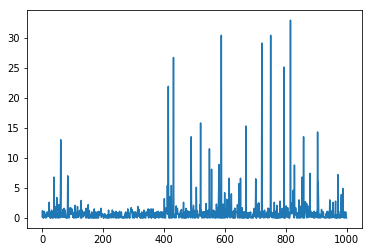

In [146]:
sorted_hist = sorted(hist, key=lambda x: x[0], reverse = False)
values = [elem[1] for elem in sorted_hist]
import matplotlib.pyplot as plt
plt.plot(values)

In [147]:
entropy(values)

tensor(8.2367)

In [ ]:
#on test
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist, tk = diversity(learn, 10, 95)
n, hist, tk

at batch no 0
at batch no 100


In [84]:
n, hist, tk

(121,
 [(854, 21904.10),
  (971, 17531.10),
  (815, 1360.20),
  (808, 843.60),
  (84, 633.90),
  (594, 553.60),
  (645, 518.80),
  (509, 220.10),
  (973, 211.70),
  (646, 173.30),
  (944, 165.30),
  (109, 152.40),
  (748, 109.90),
  (800, 93.40),
  (354, 91.10),
  (735, 81.60),
  (824, 78.20),
  (506, 74.20),
  (839, 65.90),
  (878, 65.80),
  (946, 64.40),
  (581, 63.70),
  (582, 53.80),
  (879, 50.80),
  (611, 49.00),
  (300, 46.50),
  (992, 46.00),
  (790, 44.90),
  (679, 44.40),
  (533, 44.00),
  (687, 42.20),
  (459, 40.70),
  (911, 38.50),
  (497, 38.30),
  (621, 37.30),
  (468, 35.50),
  (737, 35.40),
  (721, 34.40),
  (580, 33.80),
  (788, 32.70),
  (955, 32.00),
  (898, 31.70),
  (738, 31.50),
  (128, 31.30),
  (489, 31.00),
  (794, 30.70),
  (982, 30.50),
  (865, 30.40),
  (323, 30.00),
  (987, 28.90),
  (476, 28.50),
  (723, 28.10),
  (455, 27.70),
  (880, 27.10),
  (741, 27.00),
  (885, 26.80),
  (136, 26.50),
  (304, 26.10),
  (709, 25.80),
  (411, 25.60),
  (241, 25.00),
 

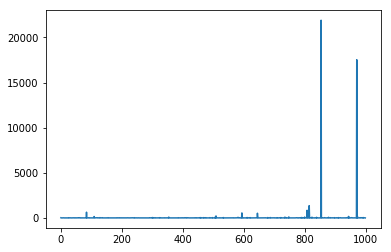

In [85]:
# on test
sorted_hist = sorted(hist, key=lambda x: x[0], reverse = False)
values = [elem[1] for elem in sorted_hist]
import matplotlib.pyplot as plt
plt.plot(values)

In [86]:
#on test
entropy(values)

tensor(2.9986)

In [ ]:
def make_triplet_samples(z, margin, r2, r3):
  positive_sample = z + random_vector_volume(z.shape, 0, margin).cuda() 
  negative_sample = z + random_vector_volume(z.shape, r2, r3).cuda()
  return positive_sample, negative_sample

def random_vector_surface(shape, r = 1.):
  mat = torch.randn(size=shape).cuda()
  norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
  return (mat/norm) * r

def random_vector_volume(shape, inner_r, outer_r):
  fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
  fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
  fraction.unsqueeze_(-1)
  return random_vector_surface(shape, 1) * fraction

In [ ]:
from collections import Counter

def most_frequent(x):
  return Counter(x).most_common(1)[0]

def preds_around(center, radius, n_preds, model, dummy_img):
  z_s = random_vector_volume([n_preds, 10], radius, radius + 0.01) + center[None]
  noises = model.forward_z(z_s)
  perturbed_imgs = noises + dummy_img 
  return torch.argmax(arch(perturbed_imgs), 1)
  
def most_freq_pred_around(center, radius, n_preds, model, dummy_img):
  preds = preds_around(center, radius, n_preds, model, dummy_img)
  most_freq = most_frequent(preds.tolist())
  return (class_index_to_label(most_freq[0]), most_freq[1]/n_preds)

def investigate_neighborhood(z, step, model, dummy_img):
  with torch.no_grad():
    result = []
    for radius in np.arange(0.1, 6., step):
#       print("creating {} more preds".format(int(10 + 5 * (radius ** 2))))
      most_freq_pred = most_freq_pred_around(z, radius, int(10 + 5 * (radius ** 2)), model, dummy_img)
      result.append((radius, most_freq_pred))
    return result

In [ ]:
#experiment 1

z = torch.tensor([0.5] * 10).cuda()
# z = torch.empty(10).uniform_(-1, 1).cuda()
# z_s = z[None]

model = learn.model.eval()
x_img = normalize(learn.data.train_ds[50][0].data.cuda())
  
for i in range(6):
  z = torch.empty(10).uniform_(-1, 1).cuda()
  print("investigation for: ", z)
  for elem in investigate_neighborhood(z, 0.5, model, x_img):
    print(elem)
print("done")

In [ ]:
#experiment 1-1: modified investigate_z
z_investigate_path = '/root/Derakhshani/adversarial/textual_notes/investigate_z_{}.txt'.format(env.save_filename)
if Path(z_investigate_path).exists(): raise FileExistsError("file already exists")
file = open(str(z_investigate_path), 'w')
        
for i, (z, noise) in enumerate(zip(pruned_z_s, pruned_noises)):
  hist = compute_prediction_histogram(learn, noise)
  indexed_hist = [(i, val) for i, val in enumerate(hist)]
  sorted_hist = sorted(indexed_hist, key=lambda x: x[1], reverse=True)
  labeled_hist = [(class_index_to_label(i), count) for i, count in sorted_hist]
  print("result {}:".format(i))
  print(big_vector_to_str(z))
  print(labeled_hist[:6])
  print("\n\n")
  
  file.write("result {}:\n".format(i))
  file.write(big_vector_to_str(z) + "\n")
  file.write(str(labeled_hist[:6]))
  file.write("\n\n\n")
  file.flush()

In [ ]:
#experiment 2
import itertools
z_s = [torch.tensor(t).cuda() for t in itertools.product( *([[-0.33, 0.33]] * 10) )]
model = learn.model.eval()
noises = []
with torch.no_grad():
  for z in z_s:
    noises.append(model.forward_single_z(z))

In [ ]:
x_img = normalize(learn.data.train_ds[50][0].data.cuda())

preds = []
for noise in noises:
  perturbed_img = x_img + noise
  preds.append(torch.argmax(arch(perturbed_img[None]), 1)[0].item())

from collections import Counter
result = [(class_index_to_label(index), count) for index, count in Counter(preds).most_common(5)]
result

In [ ]:
#experiment 3
import itertools
dimension_values = [[-0.9, 0.9]] * z_dim
for i in range(z_dim):
  if i % 100 != 0:
    dimension_values[i] = [0.]
# dimension_values[0] = [0.]
# dimension_values[3] = [0.]
# dimension_values[6] = [0.]
# dimension_values[9] = [0.]
pruned_z_s = [torch.tensor(t).cuda() for t in itertools.product(*dimension_values)]
model = learn.model.eval()
with torch.no_grad():
  pruned_noises = [model.forward_single_z(z) for z in pruned_z_s]

In [ ]:
#experiment 3: for the targeted-attack case
pruned_z_s = []
for i in range(z_dim):
  new_z = torch.zeros(z_dim).cuda()
  new_z[i] = 1.
  pruned_z_s.append(new_z)
  
model = learn.model.eval()
with torch.no_grad():
  pruned_noises = [model.forward_single_z(z) for z in pruned_z_s]

In [ ]:
#experiment 3-1: noises for 
pruned_z_s = []
# for i in range(z_dim):
#   new_z = torch.empty(z_dim).uniform_(0,1).cuda().detach()
#   pruned_z_s.append(new_z)

for i in range(z_dim):
  new_z = torch.zeros(z_dim).cuda().detach()
  new_z[i] = 1.
  pruned_z_s.append(new_z)
  
model = learn.model.eval()
with torch.no_grad():
  pruned_noises = [model.forward_single_z(z) for z in pruned_z_s]

In [ ]:
for noise in pruned_noises[0:200]:
  img = noise_to_image(noise)
  img.show()

In [ ]:
# spider web
z_values = [
  [ 0.33, -0.33,  0.33,  0.33, -0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [ 0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33],
  [-0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33,  0.33],
  [-0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33, -0.33,  0.33,  0.33, -0.33, -0.33,  0.33, -0.33,  0.33, -0.33],
  [-0.33,  0.33, -0.33,  0.33,  0.33, -0.33,  0.33,  0.33,  0.33,  0.33],
  [-0.33,  0.33,  0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33],
  [ 0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [ 0.33, -0.33,  0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33],
  [ 0.33,  0.33, -0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33],
  [ 0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33,  0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33, -0.33],
  [ 0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33],
]

if any(z_values.count(x) > 1 for x in z_values):
  raise Exception("duplicate")
  
z_s = [torch.tensor(z).cuda() for z in z_values]
model = learn.model.eval()

for z in z_s:
  img = noise_to_image(model.forward_single_z(z))
  img.show()


In [ ]:
z_values = [
  # window screen
  [-0.33,  0.33,  0.33, -0.33, -0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33],
]

if any(z_values.count(x) > 1 for x in z_values):
  raise Exception("duplicate")
  
z_s = [torch.tensor(z).cuda() for z in z_values]
model = learn.model.eval()

for z in z_s:
  img = noise_to_image(model.forward_single_z(z))
  img.show()

In [ ]:
#vgg-16_12 most repeated labels:
l = [(611, 215.0),
  (474, 194.1),
  (398, 120.3),
  (721, 79.6),
  (741, 73.5),
  (510, 62.5)]

[(class_index_to_label(index), count) for index, count in l]

In [ ]:
# learn.recorder.plot_losses()
# learn.recorder.plot_lr()
# learn.recorder.plot_metrics()

In [ ]:
fooling_rates = []
model = learn.model.eval()
learn.metrics = [validation_single_perturbation]
for i in range(10):
  global_perturbations = model(torch.rand(1, 3, 224, 244).cuda())[0]
  nag_util.global_perturbations = global_perturbations
  fooling_rates.append(learn.validate()[1].cpu().item())
  print("%d : %f"%(i, fooling_rates[-1]))

mean = np.mean(fooling_rates)
stddev = np.std(fooling_rates)
print(mean, stddev); print(fooling_rates)

In [ ]:
#the Image works good for floats in range [0..1]
model = learn.model.eval()

x_img = learn.data.train_ds[200][0]
x = normalize(x_img.data.cuda())
z = torch.tensor([-0.33,  0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33], dtype=torch.float32).cuda()
# z = torch.empty(z_dim).uniform_(-1,1).cuda()
p = model.forward_single_z(z).detach()

p_x = x + p
# print("img range, noise range")
# print_range(x); print_range(p)
adv_label = class_index_to_label(arch(p_x[None]).argmax(1).item())
print_big_vector(arch(p_x[None])[0])
p_x = denormalize(p_x)
p_x.clamp_(0,1)


#prepare images
p_x_img = Image(p_x)
p = scale_to_range(p, [0., 1.])
p_img = Image(p)
x_img.show()
p_img.show()
p_x_img.show()


# print_range(p)
# print_range(denormalize(x))
# print_range(p_x)

benign_label = class_index_to_label(arch(x[None]).argmax(1).item())

print_big_vector(arch(x[None])[0])
print(benign_label, adv_label)

In [ ]:
z1 = torch.tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p1 = model.forward_single_z(z1)

z2 = torch.tensor([1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p2 = model.forward_single_z(z2)

z3 = torch.tensor([1, 1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p3 = model.forward_single_z(z3)

l2_distance(p1, p3)

In [ ]:
#the Image works good for floats in range [0..1]
model = learn.model.eval()

x_img = learn.data.train_ds[4][0]
x = x_img.data[None].cuda()
p = model(x)[0].squeeze().detach() 
x = x.squeeze()
x = normalize(x)

p_x = x + p
p_x = denormalize(p_x)
p_x.clamp_(0,1)


#prepare images
p_x_img = Image(p_x)
p = scale_to_range(p, [0.,1.])
p_img = Image(p)
# x_img.show()
p_img.show()
# p_x_img.show()

print_range(p)
print_range(x)
print_range(p_x)